# Evaluation of mapping performance of `moscot.spatiotemporal` applied to the MOSTA dataset

Imports mapping results after running the grid search using `run_mosta_st_map.py`.


In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import os
import sys

In [3]:
from datetime import datetime
import numpy as np
from copy import copy
import glob

import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", FutureWarning)

## Set parameters

In [5]:
import mplscience
mplscience.set_style()
plt.rcParams["legend.scatterpoints"] = 1

In [10]:
color_dict = {
    "SpatioTemporal (LR)":"#332288",
    "SpatioTemporal":"#332288",
    "Temporal (LR)":"#999933",
    "Temporal":"#999933",
    "TOME": "#339999",
    "PASTE2":"#e6bf00"
}

In [7]:
sys.path.insert(
    0, "../../../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "space/spatiotemporal/"
DATA_DIR =  DATA_DIR / "space/spatiotemporal/"

## Dependencies

Requires running:

1. `0_Data_preparation/ZP_2023-04-20_spatiotemporal_fullembryo-preprocess.ipynb`: creates `mouse_embryo_all_stage_renormalized.h5ad`
 and independent anndata files for each pair in the data `mouse_embryo_{tp_i}_{tp_j}_renormalized.h5ad` consecutive $\forall i,j$s.
3. `1_Cell_type_transition_analysis/0_grid_search/`: running `0_moscot`, `1_TOME`, and `2_PASTE2` to create `.csv` accuracy files


## Load scores

In [8]:
tps_couple = np.asarray([
        [9.5, 10.5],
        [10.5, 11.5],
        [11.5, 12.5],
        [12.5, 13.5],
        [13.5, 14.5],
        [14.5, 15.5],
        [15.5, 16.5]
])

In [9]:
filenames = glob.glob(DATA_DIR + "output/*.csv")

In [11]:
res = None
for file in filenames:
    if os.stat(file).st_size:
        split_ = file.split("/")[-1].split("_")
        epsilon = split_[3]
        rank = split_[5]
        gamma = split_[7]
        alpha = split_[9]
        start = float(split_[11] + ".5")
        end = float(split_[13] + ".5")
        tp_ind = np.argwhere(tps_couple[:, 0] == start)[0][0]
        cost = split_[-1].split(".")[0]
        df = pd.read_csv(file) #, index_col=0)
        df["tp_ind"]=tp_ind
        df["tp"]=f"E{start}-E{end}"
        df["rank"]=rank
        df["gamma"]=gamma
        df["epsilon"]=epsilon
        df["alpha"]=alpha
        df["cost"]=cost
        df["type"]="moscot"
        if res is None:
            res = df
        else:
            res = pd.concat([res, df])
    else:
        print(file)
    

In [12]:
filenames_tome = glob.glob(DATA_DIR + "output_tome/*.csv")

In [13]:
res_tome = None
for file in filenames_tome:
    split_ = file.split("/")[-1].split("_")
    tp = split_[-1].split(".")[0]
    start, end = tps_couple[int(tp)]
    df = pd.read_csv(file)
    for row in df.values:
        df_ = pd.DataFrame.from_dict({
                "tp":[f"E{start}-E{end}"],
                "tp_ind":[tp],
                "rank":[None],
                "gamma":[None],
                "epsilon":[None],
                "alpha":[None],
                "cost": [None],
                "accuracy":[row[-1]],
                "tau_a":[None],
                "tau_b":[None],
                "type": ["TOME"],
                "prob_type": ["TOME"]
        })
        if res_tome is None:
            res_tome = df_
        else:
            res_tome = pd.concat([res_tome, df_])
    

In [14]:
filenames_paste = glob.glob(DATA_DIR + "output_paste2/*.csv")

In [15]:
res_paste = None
for file in filenames_paste:
    split_ = file.split("/")[-1].split("_")
    random_state = split_[-1].split(".")[0]
    tp = split_[-2]
    start, end = tps_couple[int(tp)]
    df = pd.read_csv(file)
    for row in df.values:
        df_ = pd.DataFrame.from_dict({
                "random_state": random_state,
                "tp":[f"E{start}-E{end}"],
                "tp_ind":[tp],
                "rank":[None],
                "gamma":[None],
                "epsilon":[None],
                "alpha":[None],
                "cost": [None],
                "accuracy":[row[-1]],
                "tau_a":[None],
                "tau_b":[None],
                "type": ["PASTE2"],
                "prob_type": ["PASTE2"]
        })
        if res_paste is None:
            res_paste = df_
        else:
            res_paste = pd.concat([res_paste, df_])
    

In [16]:
res["type"] = "SpatioTemporal"
res.loc[res["alpha"] == "0.0", "type"] = "Temporal"

res["type_lr"] = "SpatioTemporal (LR)"
res.loc[res["alpha"] == "0.0", "type_lr"] = "Temporal (LR)"

res["balanced"] = "un-balanced"
res.loc[(res["tau_a"] == 1.0) & (res["tau_b"] == 1.0), "balanced"] = "balanced"

res["prob_type"] = res["type"] + " (LR, " + res["balanced"]  + ")"
res.head()

,Unnamed: 0,tau_a,tau_b,accuracy,scale_cost,converged,costs_last,n_iters,tp_ind,tp,rank,gamma,epsilon,alpha,cost,type,type_lr,balanced,prob_type
0,0,0.01,0.01,0.141750,max_cost,True,0.003348411580845297_0.0033356000206625205,2,4,E13.5-E14.5,500,100.0,0.0001,0.8,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)"
1,1,0.01,0.05,0.433648,max_cost,True,0.003163726568695267_0.003096768869166651,2,4,E13.5-E14.5,500,100.0,0.0001,0.8,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)"
2,2,0.01,1.00,0.142684,max_cost,True,0.009808892636121568_0.009640694052643381,2,4,E13.5-E14.5,500,100.0,0.0001,0.8,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)"
3,3,0.05,0.01,0.421841,max_cost,True,0.0032941943818906973_0.0032098444402314237,2,4,E13.5-E14.5,500,100.0,0.0001,0.8,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)"
4,4,0.05,0.05,0.422627,max_cost,True,0.00381382599894662_0.003717893759673757,2,4,E13.5-E14.5,500,100.0,0.0001,0.8,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)"


In [17]:
res["accuracy"] = res["accuracy"].astype(float)
res = res.reset_index()

In [18]:
res_max = res.loc[res.groupby(["tp", "prob_type"])["accuracy"].idxmax(), :].copy()

In [20]:
tps = ['E9.5-E10.5', 'E10.5-E11.5', 'E11.5-E12.5', 'E12.5-E13.5', 'E13.5-E14.5', 'E14.5-E15.5', 'E15.5-E16.5']

In [21]:
for tp in tps:
    alphas = res[res["tp"] == tp]["alpha"].unique()
    print(f"{tp}:{alphas}")

E9.5-E10.5:['0.2' '0.9' '0.8' '0.0' '0.4' '0.6']
E10.5-E11.5:['0.4' '0.6' '0.9' '0.0' '0.8' '0.2']
E11.5-E12.5:['0.8' '0.6' '0.2' '0.9' '0.0' '0.4']
E12.5-E13.5:['0.0' '0.4' '0.6' '0.8' '0.2' '0.9']
E13.5-E14.5:['0.8' '0.0' '0.2' '0.4' '0.9' '0.6']
E14.5-E15.5:['0.4' '0.2' '0.6' '0.0' '0.8']
E15.5-E16.5:['0.6' '0.8' '0.0' '0.2' '0.4']


In [22]:
for val in ["alpha", "epsilon", "tau_a", "tau_b", "rank", "gamma", "scale_cost", "accuracy" , "costs_last", "converged"]:
    print(f"optimal {val}:")
    optimal_val = res_max[(res_max["prob_type"] == "SpatioTemporal (LR, un-balanced)")][["tp_ind", "tp", val]]
    print(optimal_val.sort_values(by="tp_ind")[val].values)
    

optimal alpha:
['0.4' '0.6' '0.2' '0.6' '0.6' '0.4' '0.6']
optimal epsilon:
['0.0001' '0.0001' '0.0001' '0.0001' '0.0001' '0.0001' '0.0001']
optimal tau_a:
[1.   0.05 0.01 1.   0.01 1.   1.  ]
optimal tau_b:
[0.01 1.   1.   0.01 1.   0.05 0.01]
optimal rank:
['500' '500' '500' '500' '500' '500' '500']
optimal gamma:
['100.0' '100.0' '100.0' '100.0' '100.0' '100.0' '100.0']
optimal scale_cost:
['max_cost' 'max_cost' 'max_cost' 'max_cost' 'max_cost' 'max_cost'
 'max_cost']
optimal accuracy:
[0.36704162 0.39218253 0.39142227 0.39105698 0.48793794 0.49104312
 0.45728599]
optimal costs_last:
['0.08560951994509024_0.08557255503823347'
 '0.034646706279427536_0.03464100162682919'
 '0.22700430407061717_0.2265780732878149'
 '0.03323227730773162_0.03320907627862501'
 '0.025675736950355042_0.02553808423478854'
 '0.06995206520912345_0.06990533655541785'
 '0.026907507964625155_0.026874263215898635']
optimal converged:
[ True  True  True  True  True  True  True]


In [23]:
for val in ["alpha", "epsilon", "tau_a", "tau_b", "rank", "gamma", "scale_cost", "accuracy", "costs_last", "converged"]:
    print(f"optimal {val}:")
    optimal_val = res_max[(res_max["prob_type"] == "Temporal (LR, un-balanced)")][["tp_ind", "tp", val]]
    print(optimal_val.sort_values(by="tp_ind")[val].values)


optimal alpha:
['0.0' '0.0' '0.0' '0.0' '0.0' '0.0' '0.0']
optimal epsilon:
['0.0001' '0.0001' '0.0001' '0.0001' '0.0001' '0.0001' '0.0001']
optimal tau_a:
[1.   0.01 0.01 0.01 0.01 0.01 0.01]
optimal tau_b:
[0.01 0.05 1.   0.01 0.01 0.01 0.01]
optimal rank:
['500' '500' '500' '500' '500' '500' '500']
optimal gamma:
['100.0' '100.0' '100.0' '100.0' '100.0' '100.0' '100.0']
optimal scale_cost:
['max_cost' 'max_cost' 'max_cost' 'max_cost' 'max_cost' 'max_cost'
 'max_cost']
optimal accuracy:
[0.31083868 0.31857121 0.38604736 0.34530021 0.44232522 0.47970246
 0.35383009]
optimal costs_last:
['0.08583101171677962_0.08579922938485433'
 '0.0468661897615314_0.04684553587646239'
 '0.08008994426662233_0.08007573210785479'
 '0.019628219864409616_0.0196221309997412'
 '0.018973744230683716_0.01895792789161506'
 '0.018663905659841672_0.018641164139686882'
 '0.018956333100340853_0.01892470929702565']
optimal converged:
[ True  True  True  True  True  True  True]


In [24]:
res_max_unbal = res_max[res_max["balanced"] == "un-balanced"]

In [25]:
res_full = pd.concat([res_max_unbal, res_tome, res_paste])

In [26]:
hue_order = ['SpatioTemporal',
            'Temporal',
             'TOME']

In [27]:
res_full

,index,Unnamed: 0,tau_a,tau_b,accuracy,scale_cost,converged,costs_last,n_iters,tp_ind,...,rank,gamma,epsilon,alpha,cost,type,type_lr,balanced,prob_type,random_state
53,5.0,5.0,0.05,1.00,0.392183,max_cost,True,0.034646706279427536_0.03464100162682919,3.0,1,...,500,100.0,0.0001,0.6,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)",NaN
293,1.0,1.0,0.01,0.05,0.318571,max_cost,True,0.0468661897615314_0.04684553587646239,2.0,1,...,500,100.0,0.0001,0.0,euclidean,Temporal,Temporal (LR),un-balanced,"Temporal (LR, un-balanced)",NaN
209,2.0,2.0,0.01,1.00,0.391422,max_cost,True,0.22700430407061717_0.2265780732878149,2.0,2,...,500,100.0,0.0001,0.2,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)",NaN
261,2.0,2.0,0.01,1.00,0.386047,max_cost,True,0.08008994426662233_0.08007573210785479,2.0,2,...,500,100.0,0.0001,0.0,euclidean,Temporal,Temporal (LR),un-balanced,"Temporal (LR, un-balanced)",NaN
87,6.0,6.0,1.00,0.01,0.391057,max_cost,True,0.03323227730773162_0.03320907627862501,2.0,3,...,500,100.0,0.0001,0.6,euclidean,SpatioTemporal,SpatioTemporal (LR),un-balanced,"SpatioTemporal (LR, un-balanced)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,NaN,NaN,NaN,NaN,0.308750,NaN,NaN,NaN,NaN,2,...,None,None,None,None,None,PASTE2,NaN,NaN,PASTE2,36489
0,NaN,NaN,NaN,NaN,0.156250,NaN,NaN,NaN,NaN,1,...,None,None,None,None,None,PASTE2,NaN,NaN,PASTE2,4698
0,NaN,NaN,NaN,NaN,0.286875,NaN,NaN,NaN,NaN,2,...,None,None,None,None,None,PASTE2,NaN,NaN,PASTE2,59707
0,NaN,NaN,NaN,NaN,0.370625,NaN,NaN,NaN,NaN,4,...,None,None,None,None,None,PASTE2,NaN,NaN,PASTE2,50349


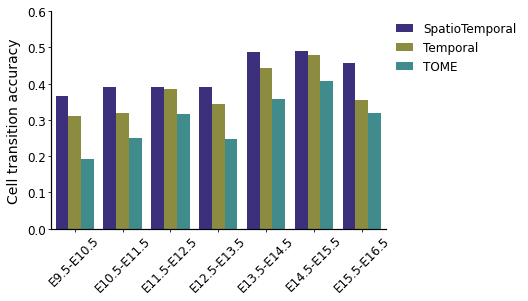

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))
ax = sns.barplot(
    x="tp",
    y="accuracy", 
    hue="type",
    hue_order = hue_order,
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res_full,
    ax=axs,
    palette=[color_dict[c] for c in hue_order]
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 0.6)
plt.xlabel("")
plt.ylabel("Cell transition accuracy")
plt.xticks(rotation=45)
plt.savefig(FIG_DIR + "st_accuracy.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [50]:
diffs = []
diffs_t = []
for tp in tps:
    acc_tome= res_full[(res_full["tp"] == tp) & (res_full["type"] == "TOME")]["accuracy"].mean()
    acc_st = res_full[(res_full["tp"] == tp) & (res_full["type"] == "SpatioTemporal")]["accuracy"].mean()
    acc_t = res_full[(res_full["tp"] == tp) & (res_full["type"] == "Temporal")]["accuracy"].mean()
    diff = acc_st-acc_tome
    diff_t = acc_st-acc_t
    diffs.append(diff)
    diffs_t.append(diff_t)
    print(f"{tp}:{acc_st:.2f}-{acc_tome:.2f}={diff:.2f}")
    print(f"{tp}:{acc_st:.2f}-{acc_t:.2f}={diff_t:.2f}")
print(f"diff mean:{np.mean(diffs):.2f}")
print(f"diff temp mean:{np.mean(diffs_t):.2f}")

E9.5-E10.5:0.37-0.19=0.17
E9.5-E10.5:0.37-0.31=0.06
E10.5-E11.5:0.39-0.25=0.14
E10.5-E11.5:0.39-0.32=0.07
E11.5-E12.5:0.39-0.32=0.08
E11.5-E12.5:0.39-0.39=0.01
E12.5-E13.5:0.39-0.25=0.14
E12.5-E13.5:0.39-0.35=0.05
E13.5-E14.5:0.49-0.36=0.13
E13.5-E14.5:0.49-0.44=0.05
E14.5-E15.5:0.49-0.41=0.08
E14.5-E15.5:0.49-0.48=0.01
E15.5-E16.5:0.46-0.32=0.14
E15.5-E16.5:0.46-0.35=0.10
diff mean:0.13
diff temp mean:0.05


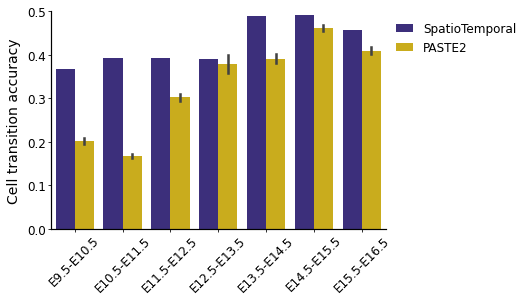

In [30]:
fig, axs = plt.subplots(1, 1, figsize=(6,4))
hue_order = ['SpatioTemporal', "PASTE2"]
ax = sns.barplot(
    x="tp",
    y="accuracy", 
    hue="type",
    hue_order = hue_order, 
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res_full,
    ax=axs,
    palette=[color_dict[c] for c in hue_order]
)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.ylim(0, 0.5)
plt.xlabel("")
plt.ylabel("Cell transition accuracy")
plt.xticks(rotation=45)
plt.savefig(FIG_DIR + "st_accuracy_subsampled.pdf", bbox_inches="tight", dpi=300)
plt.show()

In [49]:
diffs = []
for tp in tps:
    acc_paste2 = res_full[(res_full["tp"] == tp) & (res_full["type"] == "PASTE2")]["accuracy"].mean()
    acc_st = res_full[(res_full["tp"] == tp) & (res_full["type"] == "SpatioTemporal")]["accuracy"].mean()
    diff = acc_st-acc_paste2
    diffs.append(diff)
    print(f"{tp}:{acc_st:.2f}-{acc_paste2:.2f}={diff:.2f}")
print(f"diff mean:{np.mean(diffs):.2f}")

E9.5-E10.5:0.37-0.20=0.17
E10.5-E11.5:0.39-0.17=0.23
E11.5-E12.5:0.39-0.30=0.09
E12.5-E13.5:0.39-0.38=0.01
E13.5-E14.5:0.49-0.39=0.10
E14.5-E15.5:0.49-0.46=0.03
E15.5-E16.5:0.46-0.41=0.05
diff mean:0.10


In [31]:
colors = sns.blend_palette(["#332288", "#FFFFFF"], 8)
colors

[(0.2, 0.13333333333333333, 0.5333333333333333),
 (0.3129411764705883, 0.2556862745098039, 0.5992156862745098),
 (0.42901960784313725, 0.381437908496732, 0.6669281045751634),
 (0.5419607843137255, 0.5037908496732026, 0.7328104575163399),
 (0.6580392156862744, 0.6295424836601307, 0.8005228758169934),
 (0.7709803921568628, 0.7518954248366013, 0.8664052287581699),
 (0.8870588235294117, 0.8776470588235293, 0.9341176470588235),
 (1.0, 1.0, 1.0)]

In [32]:
res["alpha"].unique()

array(['0.8', '0.4', '0.0', '0.6', '0.9', '0.2'], dtype=object)

In [34]:
res_max_alpha = res.loc[res.groupby(["tp", "prob_type", "alpha"])["accuracy"].idxmax(), :].copy()

In [35]:
res_max_alpha = res_max_alpha[res_max_alpha["prob_type"].isin(["SpatioTemporal (LR, un-balanced)", "Temporal (LR, un-balanced)"])]

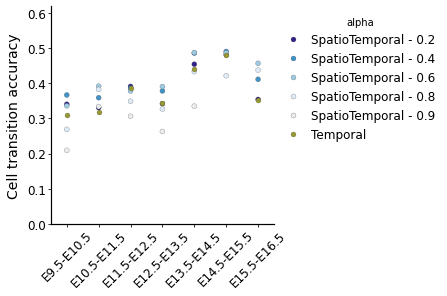

In [40]:
hue_order = ['0.2', '0.4', '0.6', '0.8', '0.9', '0.0']
fig, axs = plt.subplots(1, 1, figsize=(4,4))
ax = sns.stripplot(
    x="tp",
    y="accuracy", 
    hue="alpha", 
    hue_order=hue_order[:-1],
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res_max_alpha[res_max_alpha["alpha"] != "0.0"],
    ax=axs,
    palette=["#332288", "#4292C6",  "#9ECAE1", "#DEEBF7", "#E9EBEC", "#F1F2F3"],
    linewidth=.2,
    size=5,
    jitter=False
)

ax = sns.stripplot(
    x="tp",
    y="accuracy", 
    hue="alpha",
    order = ["E9.5-E10.5","E10.5-E11.5", "E11.5-E12.5", "E12.5-E13.5", "E13.5-E14.5","E14.5-E15.5", "E15.5-E16.5"],
    data=res_max_alpha[res_max_alpha["alpha"] == "0.0"],
    ax=axs,
    palette=["#999933", "#998844"],
    linewidth=.2,
    size=5,
    jitter=False
)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
leg = ax.axes.get_legend()
new_labels = [
    "SpatioTemporal - 0.2",
    "SpatioTemporal - 0.4",
    "SpatioTemporal - 0.6",
    "SpatioTemporal - 0.8",
    "SpatioTemporal - 0.9",
    "Temporal", 
    
]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)
    
plt.xlabel("")
plt.ylim(0, 0.62)
plt.ylabel("Cell transition accuracy")
plt.xticks(rotation=45)
plt.savefig(FIG_DIR + "st_accuracy_alpha.pdf", bbox_inches="tight", dpi=300)
plt.show()